# Podsumowanie
W tym notebook'u mamy przeprowadzony pretraining sieci. Odbywa się to blokami, które zawierają kolejne warstwy konwolucyjne. Na początku mamy pokazane obecny model. Potem mamy ukazany model, którego celem jest odtworzenie obrazka wejściowego. Chcemy to uczynić, aby nauczyć pierwsze warstwy rozpoznawania pewnych krawędzi informacji z obrazków wejściowych. Na końcu są 4 wykresy ukazujące wyniki treningu, każdego bloku. Generalnie po zakończeniu treningu każdego bloku uzyskiwaliśmy lepsze wyniki niż po treningu poprzedniego bloku (były to wyniki na poziomie 200 *Mean Absolute Error*)

## Obecny model

In [1]:
from keras.models import *
from custom_layers import BatchNormalization, Softmax4D

segnet_path = "modeleAF/model-e6dc8464-7322-4237-b669-95e4ad5819cb/"

with open(segnet_path + 'architecture.json', 'r') as json:
    segnet_load = json.read()
    
segnet = model_from_json(segnet_load, {"Softmax4D": Softmax4D, 
                                       "BatchNormalization": BatchNormalization})

segnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   73856 

In [2]:
del segnet

## Unsupervised pre-training

In [3]:
import numpy as np
from functools import partial
import itertools

def sample_generator(db_path, augment=True):
    db = np.load(db_path, allow_pickle=True)['db'][()]
    X = db['X']

    flip = [(lambda x: x), np.fliplr]
    rotate = [partial(np.rot90, k=0), partial(np.rot90, k=1), partial(np.rot90, k=2), partial(np.rot90, k=3)]
    augmentations = list(itertools.product(flip, rotate))

    while 1:
        # suffling samples
        idxs = np.random.permutation(len(X))
        for rs in idxs: # looping over shuffled samples
            if augment:
                # selecting augmentation
                aug = augmentations[np.random.randint(len(augmentations))]

                # flip rotate augmentation
                x = aug[1](aug[0](np.squeeze(X[rs])))

            else:
                x = np.squeeze(X[rs])
                
            if x.ndim == 2:
                tmp = np.zeros((x.shape[0],x.shape[1],3))
                for i in range(3):
                    tmp[:,:,i] = x
                x = tmp

            yield (x[None,:,:,:], x[None,:,:,:])
            
train_gen = sample_generator('lidc-train.npz')
val_gen = sample_generator('lidc-val.npz', False)

In [4]:
from keras.layers.convolutional import Convolution2D
from keras.layers import ZeroPadding2D, Activation, MaxPooling2D, UpSampling2D, BatchNormalization


encoding_layers = [
    [
        Input((None, None, 3)),
        ZeroPadding2D((1, 1)),
        Convolution2D(64, (3, 3), padding='valid'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2))
    ],
    [
        ZeroPadding2D((1, 1)),
        Convolution2D(128, (3, 3), padding='valid'),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2))
    ],
    [
        ZeroPadding2D((1, 1)),
        Convolution2D(256, (3, 3), padding='valid'),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2))
    ],
    [
        ZeroPadding2D((1, 1)),
        Convolution2D(512, (3, 3), padding='valid'),
        Activation('relu'),
        BatchNormalization()
    ]
]

decoder_layers = [
    [
        ZeroPadding2D((1, 1)),
        Convolution2D(512, (3, 3), padding='valid'),
        BatchNormalization()
    ],
    [
        UpSampling2D((2, 2)),
        ZeroPadding2D((1, 1)),
        Convolution2D(256, (3, 3), padding='valid'),
        BatchNormalization()
    ],
    [
        UpSampling2D((2, 2)),
        ZeroPadding2D((1, 1)),
        Convolution2D(128, (3, 3), padding='valid'),
        BatchNormalization()
    ],
    [
        UpSampling2D((2, 2)),
        ZeroPadding2D((1, 1)),
        Convolution2D(64, (3, 3), padding='valid'),
        BatchNormalization(),
        Convolution2D(3, (1, 1), padding='valid')
    ]
]

In [5]:
from keras import Sequential
from keras.optimizers import Adam
import uuid
import os

modeldir = 'model-'+str(uuid.uuid4())

def make_layer_dir(name):
    if not os.path.exists(name):
        os.makedirs(name)
    return name
    
make_layer_dir(modeldir) #directory for model

'model-57eeb59c-df0b-4224-88de-af7b25904abd'

In [6]:
from keras.callbacks import CSVLogger

logger = CSVLogger(modeldir+f'/1-conv_block.log')
pretrained = Sequential(encoding_layers[0] + decoder_layers[-1])
pretrained.compile(loss='mae', optimizer=Adam(1e-4))
pretrained.fit_generator(train_gen, 800, 100, validation_data=val_gen, 
                         validation_steps=200, callbacks=logger)
pretrained.summary()
pretrained.save_weights(modeldir+f'/1-conv_block.hdf5', save_format='h5')

C:\Users\PC-Komputer\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
800/800 [==============================] - 69s 72ms/step - loss: 821.0268 - val_loss: 822.8372
Epoch 2/100
800/800 [==============================] - 39s 49ms/step - loss: 821.9291 - val_loss: 848.9819
Epoch 3/100
800/800 [==============================] - 39s 49ms/step - loss: 820.4503 - val_loss: 815.5414
Epoch 4/100
800/800 [==============================] - 40s 50ms/step - loss: 817.7039 - val_loss: 779.1970
Epoch 5/100
800/800 [==============================] - 40s 50ms/step - loss: 813.3358 - val_loss: 817.7913
Epoch 6/100
800/800 [==============================] - 40s 50ms/step - loss: 792.7207 - val_loss: 781.6206
Epoch 7/100
800/800 [==============================] - 40s 50ms/step - loss: 803.2506 - val_loss: 801.8495
Epoch 8/100
800/800 [==============================] - 40s 50ms/step - loss: 774.0042 - val_loss: 767.1225
Epoch 9/100
800/800 [==============================] - 40s 50ms/step - loss: 770.5752 - val_loss: 757.2299
Epoch 10/100
800/800 [===============

In [7]:
def train_block(model, encoder_block, decoder_block, i):
    logger = CSVLogger(modeldir+f'/{i+1}-conv_block.log')
    
    decoder_length = sum([len(decoder_layers[k]) for k in range(-1,-(i+1), -1)])
    
    tail = [model.layers[k] for k in range(-decoder_length, 0)]
    
    for k in range(decoder_length):
        model.pop()
    
    for layer in model.layers:
        layer.trainable = False
    
    for layer in encoder_block:
        model.add(layer)
    
    for layer in decoder_block:
        model.add(layer)
    
    for layer in tail:
        model.add(layer.from_config(layer.get_config()))
          
    model.compile(loss='mae', optimizer=Adam(1e-4))
    model.fit_generator(train_gen, 800, 100, validation_data=val_gen, 
                         validation_steps=200, callbacks=logger)
    
    print(model.summary())
    model.save_weights(modeldir+f'/{i+1}-conv_block.hdf5', save_format='h5')

        
for i in range(1,len(encoding_layers)):
    encoder_block = encoding_layers[i]
    decoder_block = decoder_layers[-(i+1)]
    train_block(pretrained, encoder_block, decoder_block, i)

Epoch 1/100
800/800 [==============================] - 71s 87ms/step - loss: 838.1216 - val_loss: 839.9280
Epoch 2/100
800/800 [==============================] - 69s 87ms/step - loss: 815.7030 - val_loss: 814.6578
Epoch 3/100
800/800 [==============================] - 69s 87ms/step - loss: 813.2710 - val_loss: 799.9012
Epoch 4/100
800/800 [==============================] - 69s 87ms/step - loss: 802.4304 - val_loss: 813.1421
Epoch 5/100
800/800 [==============================] - 69s 87ms/step - loss: 806.0909 - val_loss: 781.7947
Epoch 6/100
800/800 [==============================] - 69s 87ms/step - loss: 801.0889 - val_loss: 769.4771
Epoch 7/100
800/800 [==============================] - 69s 87ms/step - loss: 773.5648 - val_loss: 790.5613
Epoch 8/100
800/800 [==============================] - 69s 87ms/step - loss: 775.0199 - val_loss: 744.4955
Epoch 9/100
800/800 [==============================] - 69s 87ms/step - loss: 761.2519 - val_loss: 731.9948
Epoch 10/100
800/800 [===============

In [8]:
decoder_length = sum([len(decoder_layers[k]) for k in range(len(decoder_layers))])
for i in range(decoder_length):
    pretrained.pop()

print(pretrained.summary())
pretrained.save_weights(modeldir + '/encoder.hdf5', save_format='h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
activation (Activation)      (None, None, None, 128)   0

## Podsumowanie, jak wyglądało trenowanie warstw

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def plot(modeldir, log_file):
    data = pd.read_csv(modeldir + '/' + log_file)
    plt.figure(figsize=(14,10))
    plt.plot(data['epoch'], data['loss'], 'b-', label='training set')
    plt.plot(data['epoch'], data['val_loss'], 'r-', label='validation set')
    plt.title(log_file[:-4])
    plt.show()

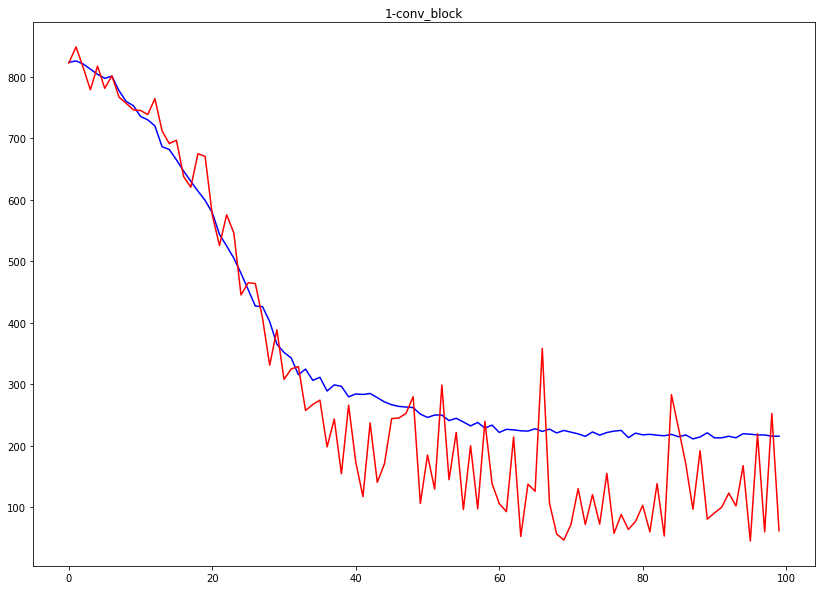

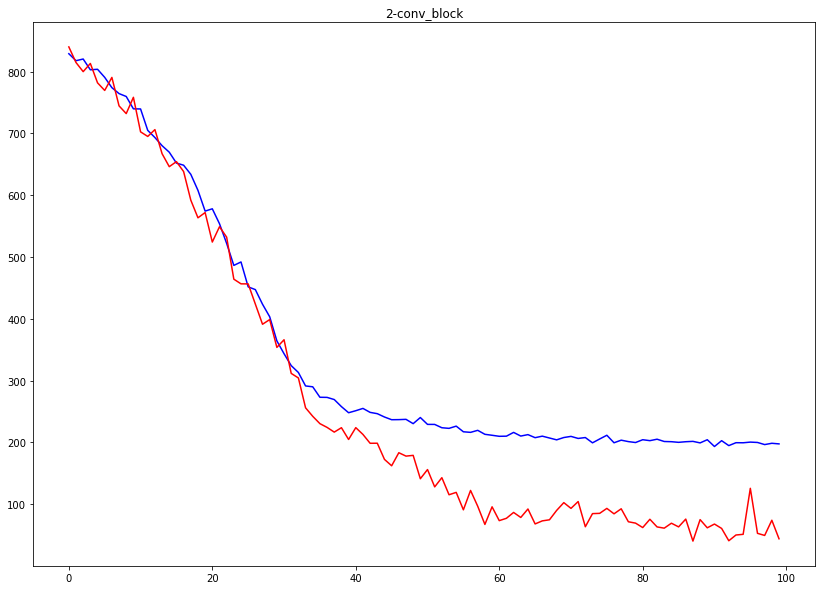

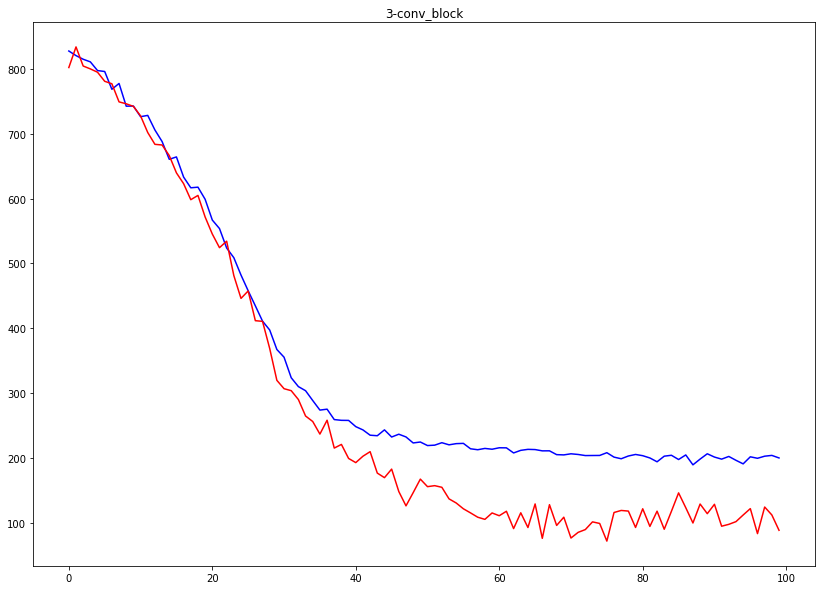

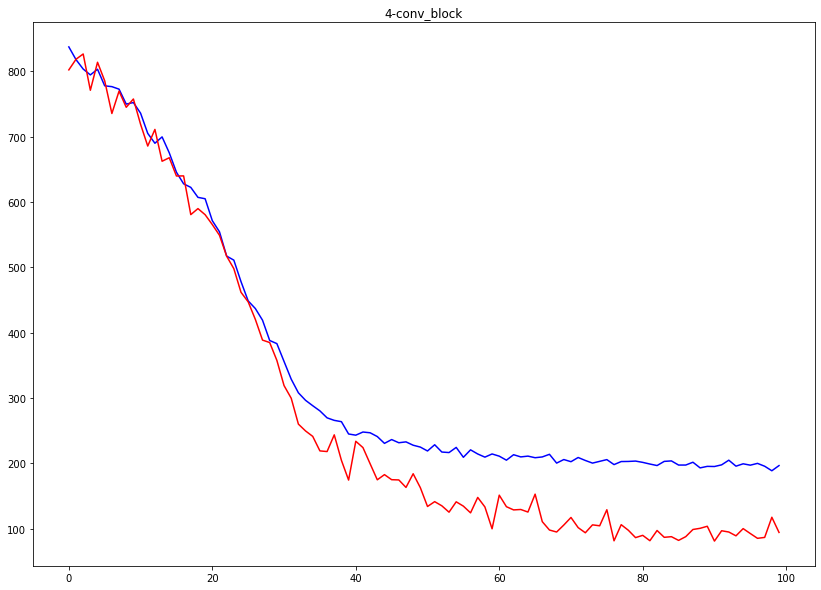

In [10]:
plot(modeldir, '1-conv_block.log')
plot(modeldir, '2-conv_block.log')
plot(modeldir, '3-conv_block.log')
plot(modeldir, '4-conv_block.log')